In [1]:
%matplotlib inline
from cox import readers
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
sns.set()

In [2]:
r = readers.CollectionReader('../src/kl_vs_no_kl_experiment/agents')

100%|██████████| 320/320 [00:30<00:00, 10.52it/s]


In [3]:
metadata = r.df('metadata')
opt = r.df('optimization')
opt['opt_step'] = opt.index
#nadv = r.df('normalized_advantage')
#nadv['opt_step'] = (nadv.index % 50) * 10
#constraints = r.df('paper_constraints_train')
#constraints_heldout = r.df('paper_constraints_heldout')

In [4]:
games =  ["Walker2d-v2", "Humanoid-v2", "Swimmer-v2", "Hopper-v2",
          "HalfCheetah-v2", "InvertedPendulum-v2", "Reacher-v2", "InvertedDoublePendulum-v2"]
code_level_opts = {
      'kl_penalty_coeff': [3, 0.0],
      #'kl_penalty_direction': ['new_to_old', 'old_to_new'],
      #'clip_advantages': [1e8],
      #'norm_rewards': ['none', 'returns'],
      #'anneal_lr': [False, True],
      #'value_clipping': [False, True],
      #'initialization': ['xavier', 'orthogonal']
}

NUM_BINS = 20

In [5]:
metadata['kl_penalty'] = (metadata['kl_penalty_coeff'] > 0)
code_level_opts = {'kl_penalty': [True, False]}
key_metadata = metadata[['exp_id', 'game'] + list(code_level_opts.keys())]
#constraints = constraints.merge(key_metadata, on='exp_id')
#constraints_heldout = constraints_heldout.merge(key_metadata, on='exp_id')
#nadv = nadv.merge(key_metadata, on='exp_id')
opt = opt.merge(key_metadata, on='exp_id')

# Plot mean rewards

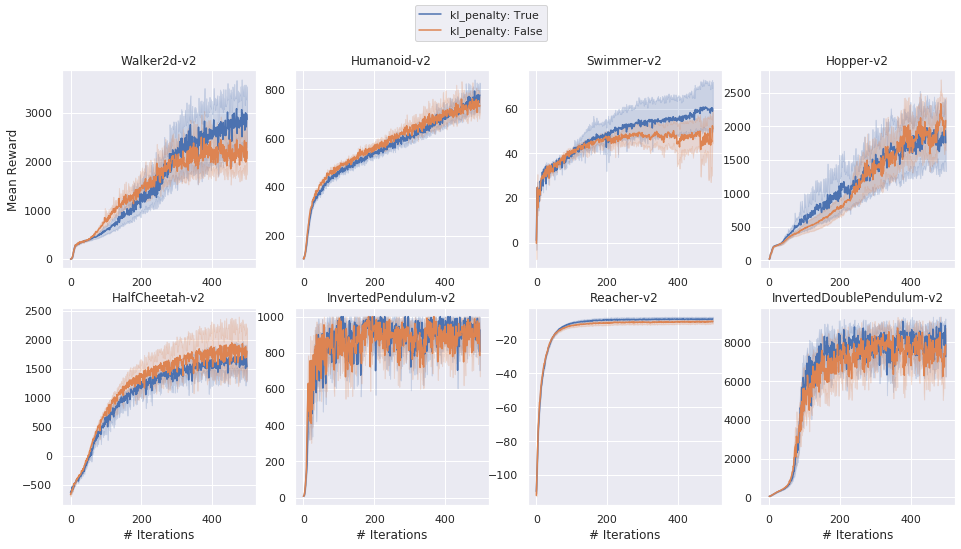

In [6]:
# Plot setup
fig, ax = plt.subplots(2, 4, figsize=(16,8))

for j, g in enumerate(games):
    for i, cl_opt in enumerate(code_level_opts):
        for b in code_level_opts[cl_opt]:
            filt = opt[(opt[cl_opt] == b) & (opt.game == g)]
            sns.lineplot(filt.opt_step, filt.mean_reward,
                         ax=ax.flatten()[j], label=f"{cl_opt}: {b}", legend=False)
        ax.flatten()[j].set_title(g)
        
for a in ax.flatten():
    a.set_ylabel('')
    a.set_xlabel('')
ax[0][0].set_ylabel('Mean Reward')
ax[1][0].set_xlabel('Mean Reward')
for a in ax[1]:
    a.set_xlabel('# Iterations')
    
handles, labels = ax[-1][-1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center')

plt.show()

# Plot cumulative distribution of max rewards

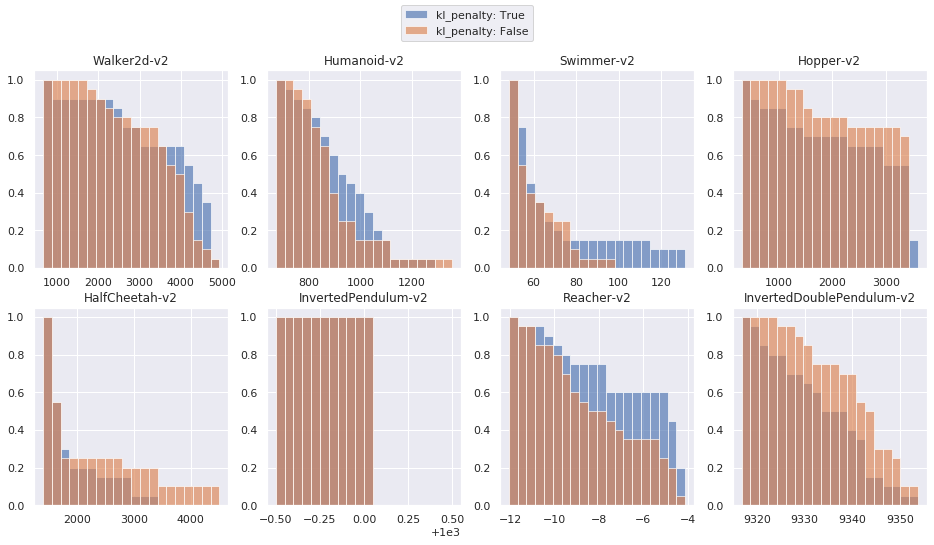

In [7]:
max_rewards = opt.groupby(['exp_id', 'game'] + list(code_level_opts.keys())).max()
max_rewards = max_rewards.reset_index()

# Plot setup
fig, ax = plt.subplots(2, 4, figsize=(16,8))

for j, g in enumerate(games):
    # Histogram setup
    _, bin_edges = np.histogram(max_rewards[max_rewards.game == g][
        'mean_reward'].tolist(), NUM_BINS)
    bin_locs = (bin_edges[:-1] + bin_edges[1:]) / 2
    bin_ws = (bin_edges[1] - bin_edges[0])
    kwargs = {'width': bin_ws, 'alpha': 0.65}
    
    for i, cl_opt in enumerate(code_level_opts):
        for ib, b in enumerate(code_level_opts[cl_opt]):
            filt = max_rewards[(max_rewards[cl_opt] == b) & (max_rewards.game == g)]
            hist, _ = np.histogram(filt['mean_reward'].tolist(), bin_edges)
            hist = np.flip(np.cumsum(np.flip(hist))) / np.sum(hist)
            ax.flatten()[j].bar(bin_locs, hist, label=f"{cl_opt}: {b}",
                                **kwargs)
        ax.flatten()[j].set_title(g)
handles, labels = ax[-1][-1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center')
plt.show()

# Plot distribution of max rewards

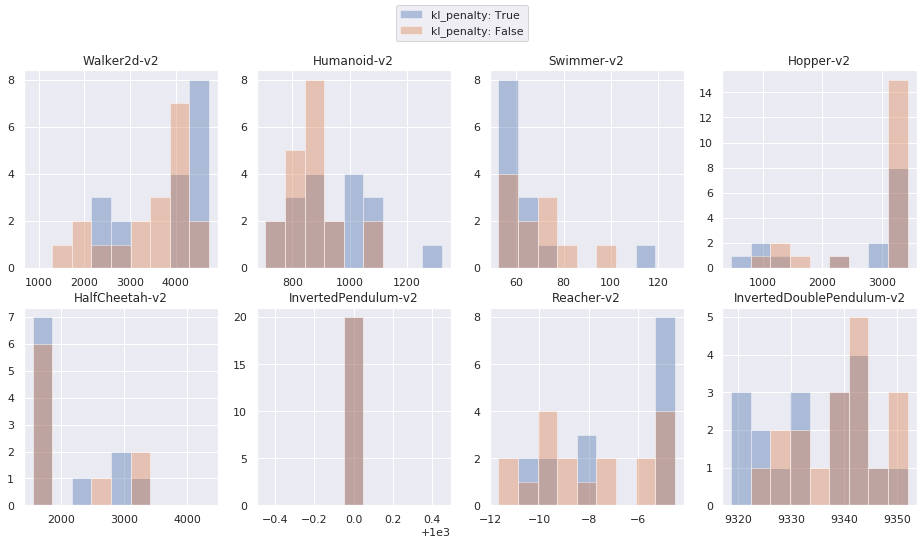

In [8]:
max_rewards = opt.groupby(['exp_id', 'game'] + list(code_level_opts.keys())).max()
max_rewards = max_rewards.reset_index()

# Plot setup
fig, ax = plt.subplots(2, 4, figsize=(16,8))

for j, g in enumerate(games):
    # Histogram setup
    _, bin_edges = np.histogram(max_rewards[max_rewards.game == g][
        'mean_reward'].tolist(), 10)
    bin_locs = (bin_edges[:-1] + bin_edges[1:]) / 2
    bin_ws = (bin_edges[1] - bin_edges[0])
    kwargs = {'width': bin_ws, 'alpha': 0.65}
    
    for i, cl_opt in enumerate(code_level_opts):
        for ib, b in enumerate(code_level_opts[cl_opt]):
            filt = max_rewards[(max_rewards[cl_opt] == b) & (max_rewards.game == g)]
            #hist, _ = np.histogram(filt['mean_reward'].tolist(), bin_edges)
            #hist = np.flip(np.cumsum(np.flip(hist))) / np.sum(hist)
            sns.distplot(filt['mean_reward'].tolist(),
                         bins=bin_locs, label=f"{cl_opt}: {b}", ax=ax.flatten()[j], kde=False)
        ax.flatten()[j].set_title(g)
handles, labels = ax[-1][-1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center')
plt.show()

# Aggregate performance in normalized scores

In [9]:
max_and_min = max_rewards[['game', 'mean_reward']].groupby('game').max().rename(
    columns={'mean_reward': 'max_max_reward'})
max_and_min['min_max_reward'] = max_rewards[['game', 'mean_reward']].groupby('game').min()

In [10]:
ks = ['game'] + list(code_level_opts.keys())
grouped = max_rewards[ks + ['mean_reward']].groupby(ks).mean().reset_index().set_index(ks)
grouped = grouped.rename(columns={'mean_reward': 'mean_max_reward'})
grouped['stddev'] = max_rewards[ks + ['mean_reward']].groupby(ks).var().reset_index().set_index(ks).apply(np.sqrt)
grouped = grouped.reset_index()
grouped = grouped.reset_index().merge(max_and_min, on='game')
grouped = grouped.set_index(ks)
grouped['normalized_score'] = (grouped['mean_max_reward'] - grouped['min_max_reward']) / (
    grouped['max_max_reward'] - grouped['min_max_reward'])
grouped['normalized_stddev'] = grouped['stddev'] / (
    grouped['max_max_reward'] - grouped['min_max_reward'])
grouped = grouped.dropna()
grouped

index  mean_max_reward       stddev  \
game                      kl_penalty                                        
HalfCheetah-v2            False           0      2064.732097  1022.003476   
                          True            1      1819.198761   558.464139   
Hopper-v2                 False           2      2875.140666   825.227163   
                          True            3      2483.437814  1185.769457   
Humanoid-v2               False           4       897.449032   145.427440   
                          True            5       928.068324   148.434677   
InvertedDoublePendulum-v2 False           6      9340.808682     8.715758   
                          True            7      9334.036522    10.638778   
Reacher-v2                False          10        -7.933812     2.488240   
                          True           11        -6.590699     2.617385   
Swimmer-v2                False          12        60.033278    12.906290   
                          True           13        66.487868    25.621395   
Walker2d-v2               False          14      3510.566256   953.969319   
                          True           15      3594.454992  1312.807171   

                                      max_max_reward  min_max_reward  \
game                      kl_penalty                                   
HalfCheetah-v2            False          4500.295480     1397.598813   
                          True           4500.295480     1397.598813   
Hopper-v2                 False          3587.873633      314.233738   
                          True           3587.873633      314.233738   
Humanoid-v2               False          1356.322800      671.755257   
                          True           1356.322800      671.755257   
InvertedDoublePendulum-v2 False          9353.824511     9316.803877   
                          True           9353.824511     9316.803877   
Reacher-v2                False            -4.108585      -12.060271   
                          True             -4.108585      -12.060271   
Swimmer-v2                False           131.266463       48.242365   
                          True            131.266463       48.242365   
Walker2d-v2               False          4936.162144      651.877180   
                          True           4936.162144      651.877180   

                                      normalized_score  normalized_stddev  
game                      kl_penalty                                       
HalfCheetah-v2            False               0.215017           0.329392  
                          True                0.135882           0.179993  
Hopper-v2                 False               0.782281           0.252082  
                          True                0.662628           0.362217  
Humanoid-v2               False               0.329688           0.212437  
                          True                0.374416           0.216830  
InvertedDoublePendulum-v2 False               0.648417           0.235430  
                          True                0.465488           0.287374  
Reacher-v2                False               0.518941           0.312920  
                          True                0.687851           0.329161  
Swimmer-v2                False               0.142018           0.155452  
                          True                0.219762           0.308602  
Walker2d-v2               False               0.667250           0.222667  
                          True                0.686831           0.306424

In [11]:
ks = ['game'] + list(code_level_opts.keys())
tmp = max_rewards[ks + ['mean_reward']].merge(max_and_min, on='game')
tmp['normalized_score'] = (tmp['mean_reward'] - tmp['min_max_reward']) / (
    tmp['max_max_reward'] - tmp['min_max_reward'])
normalized_score = tmp[['game', 'kl_penalty', 'normalized_score']]
normalized_score['game'] = normalized_score['game'].apply(lambda s: s.strip('-v2'))

/home/eecs/chloehsu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


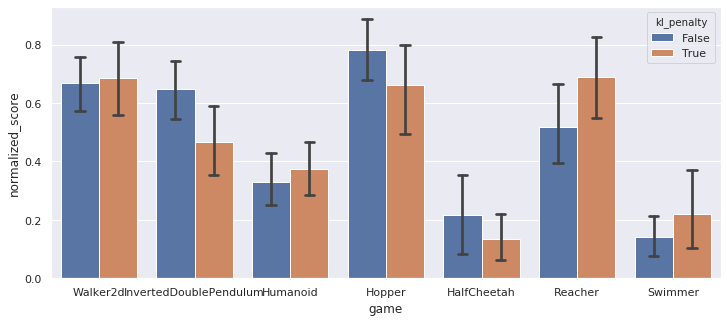

In [12]:
plt.figure(figsize=(12, 5))
sns.barplot(x="game", y="normalized_score", hue="kl_penalty", data=normalized_score.dropna().reset_index(), capsize=.1)

In [13]:
normalized_score.groupby('kl_penalty').describe()

normalized_score                                               \
                      count      mean       std  min       25%       50%   
kl_penalty                                                                 
False                 140.0  0.471945  0.336071  0.0  0.169319  0.371100   
True                  140.0  0.461837  0.354958  0.0  0.097416  0.422309   

                          
                75%  max  
kl_penalty                
False       0.80714  1.0  
True        0.87713  1.0